# Analiza widma

Celem eksperymentu będzie sprawdzenie czy analiza widma wzajemnego umożliwia odnalezienie korelacji między dwoma szeregami występujących w różnych częstotliwościach. W tym celu wygeneruje sztuczne dane na podstawie dwóch wzorów, które dla pewnych częstotliwości bedą miały silnie zsynchronizowane okresy.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Generowanie sztucznych danych 
- dwa wzory, te same częstotliwości , różne przsunięcia w czasie, czynnik losowy

In [9]:
v1 = lambda v0 : 0.9 * np.cos(2 * np.pi * 0.3 * (v0)) + 0.65 * np.sin(2 * np.pi * 0.7 * (v0)) + np.random.uniform()/500
v2 = lambda v0 : 0.9 * np.cos(2 * np.pi * 0.5 * (v0)) + 0.65 * np.sin(2 * np.pi * 0.4 * (v0)) + np.random.uniform()/500

In [12]:
def getData(start, stop, step):
    result = []
    for i in np.arange(start, stop, step):
        result.append([i, v1(i), v2(i)])
    return np.array(result)

## Wypisanie i wyświetlenie wygenerowanych danych

[[0.         0.90117607 0.90006157]
 [0.01       0.92980334 0.9163182 ]
 [0.02       0.95671607 0.93128276]
 ...
 [9.97       0.81429835 0.84883756]
 [9.98       0.84308736 0.86593188]
 [9.99       0.87270292 0.88348289]]


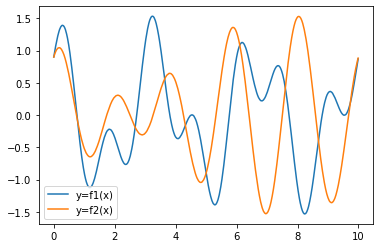

In [13]:
start = 0.0
stop = 10.0
step = 0.01

data = getData(start, stop, step)
print(data)

plt.plot(data[:,0], data[:, 1:] )
plt.legend(["y=f1(x)", "y=f2(x)"])
plt.show()

Regresja wieloraka dla obu wzorów,  gdzie zmienną zależną jest obserwowany szereg czasowy, 
a zmiennymi niezależnymi są funkcje sinus i cosinus o wszystkich możliwych (dyskretnych) częstotliwościach

# Model strukturalny

Celem analizy widmowej jest dekompozycja oryginalnego szeregu na podstawowe funkcje sinus i cosinus o różnych częstotliwościach w celu wyznaczenia tych, które okazują się szczególnie silne lub ważne. Jednym ze sposobów wykonania tego byłoby przełożenie tej kwestii na problem regresji wielorakiej , gdzie zmienną zależną jest obserwowany szereg czasowy, a zmiennymi niezależnymi są funkcje sinus o wszystkich możliwych (dyskretnych) częstotliwościach. Taki liniowy model regresji wielorakiej może być zapisany jako:

$x_t = a_0 +  \sum(a_k * cos(\lambda_{k1} * t) + b_k * sin(\lambda_{k2} * t))$   (dla $k = 1$ do $q$)

$\lambda$ - częstotliwość w radianach, wszystkie możliwe kombinacje $\\$
$a_k$ i $b_k$ - szukane parametry, jeśli dla danego k-tego zestawu częstotliwości parametr będzie wysoki, oznaczać to może, że poszukiwane są te częstotliwości

## Szkielety szukanych funkcji

In [14]:
f1 = lambda x, a1, a2, lambda1 : a1 * np.cos(2 * np.pi * lambda1 * (x)) + a2 * np.sin(2 * np.pi * lambda1 * (x))
f2 = lambda x, a1, a2, lambda1 : a1 * np.cos(2 * np.pi * lambda1 * (x)) + a2 * np.sin(2 * np.pi * lambda1 * (x))

## Generowanie kolumn
- generuje kolumny dla każdej sprawdzanej częstotliwość
- kolumny zostaną wykorzystane do stworzenia DataFrame'u, który posłuży w regresji wielorakiej

In [ ]:
# Stworzenie funkcji, które sumują powyższe
import math

def generateColumns():
    columns = ["X", "Value"]
    for i in np.arange(0.0, 1.0, 0.1):
        c1 = "lambda: " + str(i)
        c2 = "a_" + str(i)
        c3 = "b_" + str(i)
        columns.append(c1)
        columns.append(c2)
        columns.append(c3)
    return columns
       

## Generowanie danych
- tworzone są dwa DataFrame dla obu funkcji
- iteracja po pewnym przedziale x-ów, dyskretnych wartości częstotliwości oraz dyskretnych wartości współczynników $a_k$ i $b_k$
- obliczenie wartości dla wygenerowanych argumentów (jeśli wartość funkcji f1 lub f2 jest różna od tej uzyskanej z pierwotnej funckji v1 lub v2 wtedy ustawiana jest wartość 0)

In [15]:
def generateData():
    data1 = []
    data2 = []
    for x in np.arange(0.0, 10.0, 0.01):
        
        for lambda1 in np.arange(0.0, 1.0, 0.1):
            for a1 in np.arange(0.0, 1.0, 0.1):
                for a2 in np.arange(0.0, 1.0, 0.1):
                    if abs(f1(x, a1, a2, lambda1) - v1(x)) < 1e-2:
                        tmp1 = [x, f1(x, a1, a2, lambda1)]
                    else:
                        tmp1 = [x, 0]
                        
                    if abs(f2(x, a1, a2, lambda1) - v2(x)) < 1e-2:
                        tmp2 = [x, f2(x, a1, a2, lambda1)]
                    else:
                        tmp2 = [x, 0]
                    
                    for i in np.arange(0.0, 1.0, 0.1):
                        if math.isclose(lambda1, i):
                            tmp1.append(lambda1)
                            tmp1.append(a1)
                            tmp1.append(a2)
                            tmp2.append(lambda1)
                            tmp2.append(a1)
                            tmp2.append(a2)
                        else:
                            for k in range(3):
                                tmp1.append(0.0)
                                tmp2.append(0.0)
                    
                    data1.append(tmp1)
                    data2.append(tmp2)
                    
    data1 = pd.DataFrame(data1, columns=generateColumns())
    data2 = pd.DataFrame(data2, columns=generateColumns())
    return (data1, data2)
                    
    

data1, data2 = generateData()
print("Done")
    

Done


## Regresja wieloraka

In [16]:
import statsmodels.api as sm


X =  data1.drop('Value', axis=1)
print(X)
Y1 = data1["Value"]
Y2 = data2["Value"]


# Regresja wieloraka

model1 = sm.OLS(Y1, X).fit()
model2 = sm.OLS(Y2, X).fit()
predictions1 = model1.predict(X)
predictions2 = model2.predict(X)

print(predictions1)
print(predictions2)




           X  lambda: 0.0  a_0.0  b_0.0  lambda: 0.1  a_0.1  b_0.1  \
0       0.00          0.0    0.0    0.0          0.0    0.0    0.0   
1       0.00          0.0    0.0    0.1          0.0    0.0    0.0   
2       0.00          0.0    0.0    0.2          0.0    0.0    0.0   
3       0.00          0.0    0.0    0.3          0.0    0.0    0.0   
4       0.00          0.0    0.0    0.4          0.0    0.0    0.0   
...      ...          ...    ...    ...          ...    ...    ...   
999995  9.99          0.0    0.0    0.0          0.0    0.0    0.0   
999996  9.99          0.0    0.0    0.0          0.0    0.0    0.0   
999997  9.99          0.0    0.0    0.0          0.0    0.0    0.0   
999998  9.99          0.0    0.0    0.0          0.0    0.0    0.0   
999999  9.99          0.0    0.0    0.0          0.0    0.0    0.0   

        lambda: 0.2  a_0.2  b_0.2  ...  b_0.6000000000000001  \
0               0.0    0.0    0.0  ...                   0.0   
1               0.0    0.0    0

In [18]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Value   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              34.59
Date:                Tue, 01 Jun 2021   Prob (F-statistic):                   6.78e-199
Time:                        00:45:35   Log-Likelihood:                      1.6871e+06
No. Observations:             1000000   AIC:                                 -3.374e+06
Df Residuals:                  999970   BIC:                                 -3.374e+06
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
X                               0.0004   1.51e-05     23.170      0.000       0.000       0.000
lambda: 0.0                 -8.547e-18   1.38e-18     -6.201      0.000   -1.12e-17   -5.85e-18
a_0.0                           0.0028      0.000      7.372      0.000       0.002       0.004
b_0.0                          -0.0011      0.000     -2.800      0.005      -0.002      -0.000
lambda: 0.1                    -0.0172      0.004     -4.883      0.000      -0.024      -0.010
a_0.1                          -0.0002      0.000     -0.362      0.717      -0.001       0.001
b_0.1                           0.0001      0.000      0.230      0.818      -0.001       0.001
lambda: 0.2                    -0.0100      0.002     -5.656      0.000      -0.013      -0.007
a_0.2                          -0.0019      0.000     -3.920      0.000      -0.003      -0.001
b_0.2                           0.0019      0.000      3.860      0.000       0.001       0.003
lambda: 0.30000000000000004    -0.0056      0.001     -4.758      0.000      -0.008      -0.003
a_0.30000000000000004       -5.652e-05      0.000     -0.115      0.909      -0.001       0.001
b_0.30000000000000004          -0.0002      0.000     -0.317      0.751      -0.001       0.001
lambda: 0.4                    -0.0095      0.001    -10.819      0.000      -0.011      -0.008
a_0.4                           0.0025      0.000      5.043      0.000       0.002       0.003
b_0.4                           0.0022      0.000      4.509      0.000       0.001       0.003
lambda: 0.5                    -0.0037      0.001     -5.293      0.000      -0.005      -0.002
a_0.5                           0.0002      0.000      0.378      0.705      -0.001       0.001
b_0.5                        6.425e-05      0.000      0.130      0.896      -0.001       0.001
lambda: 0.6000000000000001     -0.0041      0.001     -7.005      0.000      -0.005      -0.003
a_0.6000000000000001            0.0012      0.000      2.470      0.014       0.000       0.002
b_0.6000000000000001            0.0007      0.000      1.480      0.139      -0.000       0.002
lambda: 0.7000000000000001     -0.0027      0.001     -5.305      0.000      -0.004      -0.002
a_0.7000000000000001            0.0003      0.000      0.640      0.522      -0.001       0.001
b_0.7000000000000001        -6.078e-05      0.000     -0.123      0.902      -0.001       0.001
lambda: 0.8                    -0.0033      0.000     -7.562      0.000      -0.004      -0.002
a_0.8                           0.0031      0.000      6.376      0.000       0.002       0.004
b_0.8                           0.0007      0.000      1.489      0.136      -0.000       0.002
lambda: 

In [19]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Value   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              42.68
Date:                Tue, 01 Jun 2021   Prob (F-statistic):                   3.16e-250
Time:                        00:45:38   Log-Likelihood:                      1.6395e+06
No. Observations:             1000000   AIC:                                 -3.279e+06
Df Residuals:                  999970   BIC:                                 -3.279e+06
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
X                              -0.0003   1.59e-05    -18.624      0.000      -0.000      -0.000
lambda: 0.0                  6.228e-18   1.45e-18      4.308      0.000    3.39e-18    9.06e-18
a_0.0                           0.0058      0.000     14.382      0.000       0.005       0.007
b_0.0                           0.0028      0.000      6.992      0.000       0.002       0.004
lambda: 0.1                     0.0228      0.004      6.166      0.000       0.016       0.030
a_0.1                          -0.0005      0.001     -0.986      0.324      -0.002       0.001
b_0.1                          -0.0008      0.001     -1.633      0.102      -0.002       0.000
lambda: 0.2                    -0.0027      0.002     -1.446      0.148      -0.006       0.001
a_0.2                           0.0043      0.001      8.263      0.000       0.003       0.005
b_0.2                           0.0029      0.001      5.616      0.000       0.002       0.004
lambda: 0.30000000000000004     0.0026      0.001      2.138      0.033       0.000       0.005
a_0.30000000000000004           0.0027      0.001      5.185      0.000       0.002       0.004
b_0.30000000000000004           0.0013      0.001      2.604      0.009       0.000       0.002
lambda: 0.4                 -5.601e-05      0.001     -0.061      0.952      -0.002       0.002
a_0.4                           0.0031      0.001      5.911      0.000       0.002       0.004
b_0.4                           0.0013      0.001      2.440      0.015       0.000       0.002
lambda: 0.5                     0.0005      0.001      0.670      0.503      -0.001       0.002
a_0.5                           0.0021      0.001      4.058      0.000       0.001       0.003
b_0.5                           0.0006      0.001      1.243      0.214      -0.000       0.002
lambda: 0.6000000000000001     -0.0003      0.001     -0.550      0.582      -0.002       0.001
a_0.6000000000000001            0.0037      0.001      7.138      0.000       0.003       0.005
b_0.6000000000000001            0.0017      0.001      3.281      0.001       0.001       0.003
lambda: 0.7000000000000001  -4.196e-05      0.001     -0.079      0.937      -0.001       0.001
a_0.7000000000000001            0.0015      0.001      2.814      0.005       0.000       0.002
b_0.7000000000000001            0.0021      0.001      3.972      0.000       0.001       0.003
lambda: 0.8                     0.0005      0.000      1.162      0.245      -0.000       0.001
a_0.8                           0.0033      0.001      6.479      0.000       0.002       0.004
b_0.8                        5.425e-05      0.001      0.105      0.916      -0.001       0.001
lambda: 

## Wnioski
- niestety oba otrzymane modele nie wskazują na istnienie wysokiej korelacji dla odpowiednich częstotliwości (lambd)
- jednym z powodów tego wyniku może być zbyt mały zbiór uczący